In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("Project1.ipynb")

In [190]:
rng_seed = 42

# Project 1

# <em> Optimization, Monte Carlo Problems, pocoMC </em>
<br>

Welcome to your first project. Unlike the homework, you will generally receive less guidance on projects but are still expected to do the work required. This project primarily covers sampling and the use of MCMC methods. You will be analyzing some data using a number of methods for parameter inference.

Though there will be physics involved in these projects, the physical quantities and equations are generally given to you, while you are expected to use the physics equations to produce data analysis results. Accordingly, autograder will be less through for these questions, and most of the project will be graded manually, so make sure you include documentation with your code!


### Imports

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

***

# Problem 1: Constraints on Galaxy Clustering

Parameter constraints methods are used in many physical problems. In this project, we consider the use of two different methods, Maximum Likelihood Estimation (MLE) and Markov Chain Monte Carlo (MCMC), to constrain Halo Occupation Distribution (HOD) models.

Here, we consider constraints on the Halo Occupation Distribution (HOD) models for projected galaxy clustering.

HOD models are used to interpret the relation of galaxy distributions in large scale structure to the dark matter distribution. They describe related properties of the galaxy distribution within a dark matter halo: The probability distribution of the number of galaxies within that halo in relation to the mass of the halo, the distribution in space of galaxies withing the DM halo and the distribution in velocity of galaxies in the halo.

Traditional HOD models make two assumptions: (1) that all galaxies reside in dark matter haloes and are biased tracers of the underlying matter density and (2) galaxies occupy halos **only** as a function of the halo mass $M_{vir}$. However, these are not necessarily correct, an effect called *halo assembly bias* could be significant. They also add additional parameters to the HOD model. In this problem, we will infer some HOD model parameters given some input data using MCMC.

First, we will describe the parameters. HOD models usually treat central galaxies and satellite galaxies in a halo separately, and the occupation statistics of the central galaxy will be different than the occupation statistics of the satellite galaxies in the halo.
The average number of central galaxies in a halo of mass $M$ is given by

$$\langle N_{cen}\rangle_{M} = \frac12 \left[1 + \mathrm{erf}\left( \frac{\log M - \log M_{\mathrm{min}}}{\sigma_{\log M}}\right)\right]$$

While the average number of satellite galaxies in a halo of mass $M$ is given by

$$\langle N_{sat}\rangle_{M} = \left[\frac{M-M_0}{M_1}\right]^\alpha$$

The parameter $M_{\mathrm{min}}$ describes the halo mass at which the halo has 50\% probability to host a central galaxy, while the parameter $\sigma_{\log M}$ can be considered the rate at which the likelihood of the central galaxy to exist increases alongside halo mass. The parameter $M_1$ is the halo mass at which an average halo would host one satellite galaxy, while $M_0$ is the halo mass at which an average halo would not have a satellite galaxy. $\alpha$ is the power-law exponent relation parameter between the number of satellites and the halo mass. Lastly, we also have the two parameters $A_{cen}$ and $A_{sat}$, quantify describe the halo assembly bias.

In summary, we take a likelihood model of the Halo Occupation Distribution and infer the following parameters:
$$[\log(M_{\mathrm{min}}), \sigma_{\log M}, \log(M_0), \log(M_1), \alpha, A_{cen}, A_{sat}]$$

(This problem is based on the following paper: https://arxiv.org/pdf/1606.07817.pdf)

In [192]:
import numpy as np
import corner
from scipy.stats import uniform
from tabcorr import TabCorr
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens
from halotools.empirical_models import AssembiasZheng07Sats

import numdifftools

In [ ]:
# Load data
halotab = TabCorr.read('./zentner19data/bolplanck.hdf5')
cens_occ_model = AssembiasZheng07Cens()
sats_occ_model = AssembiasZheng07Sats()
model = HodModelFactory(centrals_occupation=cens_occ_model,
                        satellites_occupation=sats_occ_model)

n_obs = 6.37e-3
n_err = 0.75e-3
wp_obs = np.genfromtxt('./zentner19data/wp_dr72_bright0_mr20.0_z0.106_nj400')[:, 1]
wp_cov = np.genfromtxt('./zentner19data/wpcov_dr72_bright0_mr20.0_z0.106_nj400')


First, we would like to define priors on the model parameters. Since we don't know too much beyond the range of the priors, we will define uniform priors for each parameter as given:

\begin{array}{ c|c }
 \text{Parameter} & \text{Prior Interval} \\
 \hline
 \log(M_{\mathrm{min}}) & [9.0, 14.0] \\
 \sigma_{\log M} & [0.01, 1.5]\\
 \log(M_0) & [9.0, 14.0]\\
 \log(M_1) & [10.7, 15.0]\\
 \alpha & [0.0, 2.0]\\
 A_{cen} & [-1.0, 1.0] \\
 A_{sat} & [-1.0, 1.0]
\end{array}

Furthermore, to constrain parameters, we need a description of the likelihood function of parameters. Here, following the accompanying paper to this problem, we define the likelihood of the form $\mathit{L} \propto e^{-\chi^2/2}$, with the $\chi^2$ given as

$$\chi^2 = \Delta w_{p,i}\, [C^{-1}]_{ij}\, \Delta w_{p, j} + \frac{(n_g^{\text{mock}} - n_g^{\text{obs}})^2}{\sigma^2_n}$$

with $ \Delta w_{p,i} \equiv w_p^{\text{mock}}(r_{p, i}) -  w_p^{\text{obs}}(r_{p, i})$ being the difference between the projected and observed two point correlation functions $w_{p}(r_{p,i})$. The observed $w_p^{\text{obs}}$ is given to you while the predicted $w_p^{\text{mock}}$ is received from the model (see below). The $r_{p,i}$ represents the 12 $r$ bins, and you can see that the given $w_p$ are indeed 12 dimensional. $C$ is the covariance matrix of the measurements (also given), and the term $\frac{(n_g^{\text{mock}} - n_g^{\text{obs}})^2}{\sigma^2_n}$ is the contribution from the difference between the predicted and measured galaxy number densities. ($n_g^{\text{mock}}$ is given by the model, while $\sigma_n$ and $n_g^{\text{obs}}$ are given from the data).

## **Problem Goals**

Using the likelihood function and priors given,  you are expected to compute constraints on the halo parameters in two different methods: first, using a **Maximum Likelihood Estimate (MLE)** approach where you assume the data is Gaussian, then using the **Metropolis-Hastings algorithm** for **Markov Chain Monte Carlo (MCMC)**. You are then expected to compare the results from these two methods and briefly discuss the differences. Lastly, compare the results to Figure 6 from https://arxiv.org/pdf/1606.07817.pdf.

<!-- BEGIN QUESTION -->

### Part 1. Define the Log Likelihood function


Given a set of data $X$ and a model $M(\theta)$ on this data with parameters $\theta$, we can define the likelihood function as the probability that the model with parameters $\theta$ describes the data:
$$L(\theta; X) = P(X | \theta)$$

Usually, we work in the log space as the log-likelihood is easier to define and optimize. As the log function is monotonic, anything that yields the maximum or minimum log-likelihood would then also yield the maximum or minimum likelihood. The log-likelihood is defined as
$$\ell(\theta;X) = \log(L(\theta; X))$$


<span style="color:blue"> <i> Using this chi square given above, define the priors and the log likelihood function.



In [ ]:
# Define log-likelihood function
names = ['logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha',
         'mean_occupation_centrals_assembias_param1',
         'mean_occupation_satellites_assembias_param1']
bounds = [(9.0, 14.0), (0.01, 1.5), (9.0, 14.0), (10.7, 15.0), (0.0, 2.0), (-1.0, 1.0), (-1.0, 1.0)]

def log_likelihood(theta):
    theta = theta.copy()
    model.param_dict.update(dict(zip(names, theta)))
    n_mod, wp_mod = halotab.predict(model)

    return -0.5 * (np.dot(wp_mod - wp_obs, np.dot(np.linalg.inv(wp_cov), (wp_mod - wp_obs))) + (((n_mod - n_obs)**2) / (n_err**2)))

In [195]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part 2. Maximum Likelihood Estimate / Maximum A Posteriori

Given a log likelihood function $\ell(\theta; X)$, in the frequentist set-up we can calculate the maximum likelihood estimate (MLE) of our parameters $\theta$ by finding the MLE best fit parameters $\widehat{\theta}$

$$\widehat{\theta} = \mathrm{argmax}_\theta \; \ell(\theta; X)$$

However, in this problem, we don't just want to find the *best fit parameters* $\widehat{\theta}$, but we also want to find the *uncertainties* of these best fit parameters, as well as the covariances of these parameters and their distribution in parameter space.

The Fisher Information Matrix could help us find the parameter covariance. Recall that the Fisher Matrix is defined as
$$F_{ij} = - \left\langle \frac{∂^2}{∂\theta_i∂\theta_j} \ell(\theta; X)\right\rangle_{\theta_{MLE}}$$
(Note that as described in the lecture notes, the fisher matrix is evaluated at the best-fit MLE parameters) The Fisher matrix also has the property such that its inverse yields the covariance matrix.
$$C^{-1} = F$$

To compute the Fisher information, we make use of the Hessian matrix of the log-likelihood. This is defined as
$$H_{ij} = \frac{∂^2}{∂\theta_i∂\theta_j} \ell(\theta; X)$$ which means that the Fisher Information matrix is the negative expectation of the Hessian
$$F = -\left\langle H \right\rangle$$

Note: this is only true in the assumption of large, independent samples from the likelihood, when distribution on $\theta$ exhibits asymptotic normality.
$$\hat{\theta} \sim N\left(\theta, \frac{F(\theta)^{-1}}{n} \right)$$
By the Laplace approximation, this indicates that the Hessian would converge to the Fisher Information Matrix.

In practice, this symbolizes that the Hessian of the log likelihood can be used to approximate the Fisher matrix. Under the assumption that the parameter space is Gaussian distributed then, we can use the Hessian of the likelihood to calculate the covariance matrix and plot Gaussian stair plots showing the distribution in parameter space.

**The goal of this section is to accomplish this task. Find the parameters that maximize the log likelihood within the prior bounds given above, and plot the parameter distributions for the parameters given, using the prior bounds as bounds of each of the stair plots.** To help in the plotting part, a skeleton stair plot code is provided, but you will have to modify the code to fit the parameters. (Note that technically, we are conducting Maximum A Posteriori (MAP) estimation of parameters as we're incorporating the uniform priors given earlier)

Hints:

1.   `scipy.optimize` allows the use of optimization methods with bounds on optimization parameters. Read the documentation and use a method that is able to do bounded optimization on the likelihood.
2.   To compute the Hessian on the log-likelihood function, use numerical finite difference methods and not automatic differentiation methods. This is because the likelihood function you constructed in Part 1 utilises packages which are not automatically differentiable by autograd or pytorch. The package `numdifftools` contains the function `numdifftools.Hessian` which will help you in this area.

In [ ]:
# Use these labels for the parameters. Make sure you use the parameters in this order for the autograder!

labels = [r'$\log M_{min}$', r'$\sigma_{\log M}$',r'$\log M_0$',r'$\log M_1$',r'$\alpha$',r'$A_c$',r'$A_s$'] 

from scipy.optimize import minimize

def neg_log_likelihood(theta):
    return -log_likelihood(theta)

opt_p = minimize(neg_log_likelihood, np.array([11.5, 0.755, 11.5, 12.85, 1.0, 0.0, 0.0]), method='L-BFGS-B', bounds=bounds)

print(opt_p.x)
for i in range(len(labels)):
    print(r"MLE value of %s = %.5f" %(labels[i], opt_p.x[i]))


[12.15663725  0.66780333 12.18372699 13.26765914  1.06058745  1.
 -0.06105078]
MLE value of $\log M_{min}$ = 12.15664
MLE value of $\sigma_{\log M}$ = 0.66780
MLE value of $\log M_0$ = 12.18373
MLE value of $\log M_1$ = 13.26766
MLE value of $\alpha$ = 1.06059
MLE value of $A_c$ = 1.00000
MLE value of $A_s$ = -0.06105


In [197]:
hess_func = numdifftools.Hessian(log_likelihood)
hessian = hess_func(opt_p.x)
fisher = -hessian
cov_matrix = np.linalg.inv(fisher)

print("Covariance matrix computed successfully")
print("Parameter uncertainties (1-sigma):")
for i in range(len(labels)):
    print("%s: %.5f +/- %.5f" % (labels[i], opt_p.x[i], np.sqrt(cov_matrix[i, i])))


Covariance matrix computed successfully
Parameter uncertainties (1-sigma):
$\log M_{min}$: 12.15664 +/- 0.17555
$\sigma_{\log M}$: 0.66780 +/- 0.26266
$\log M_0$: 12.18373 +/- 0.42571
$\log M_1$: 13.26766 +/- 0.09287
$\alpha$: 1.06059 +/- 0.07573
$A_c$: 1.00000 +/- 0.35809
$A_s$: -0.06105 +/- 0.27369


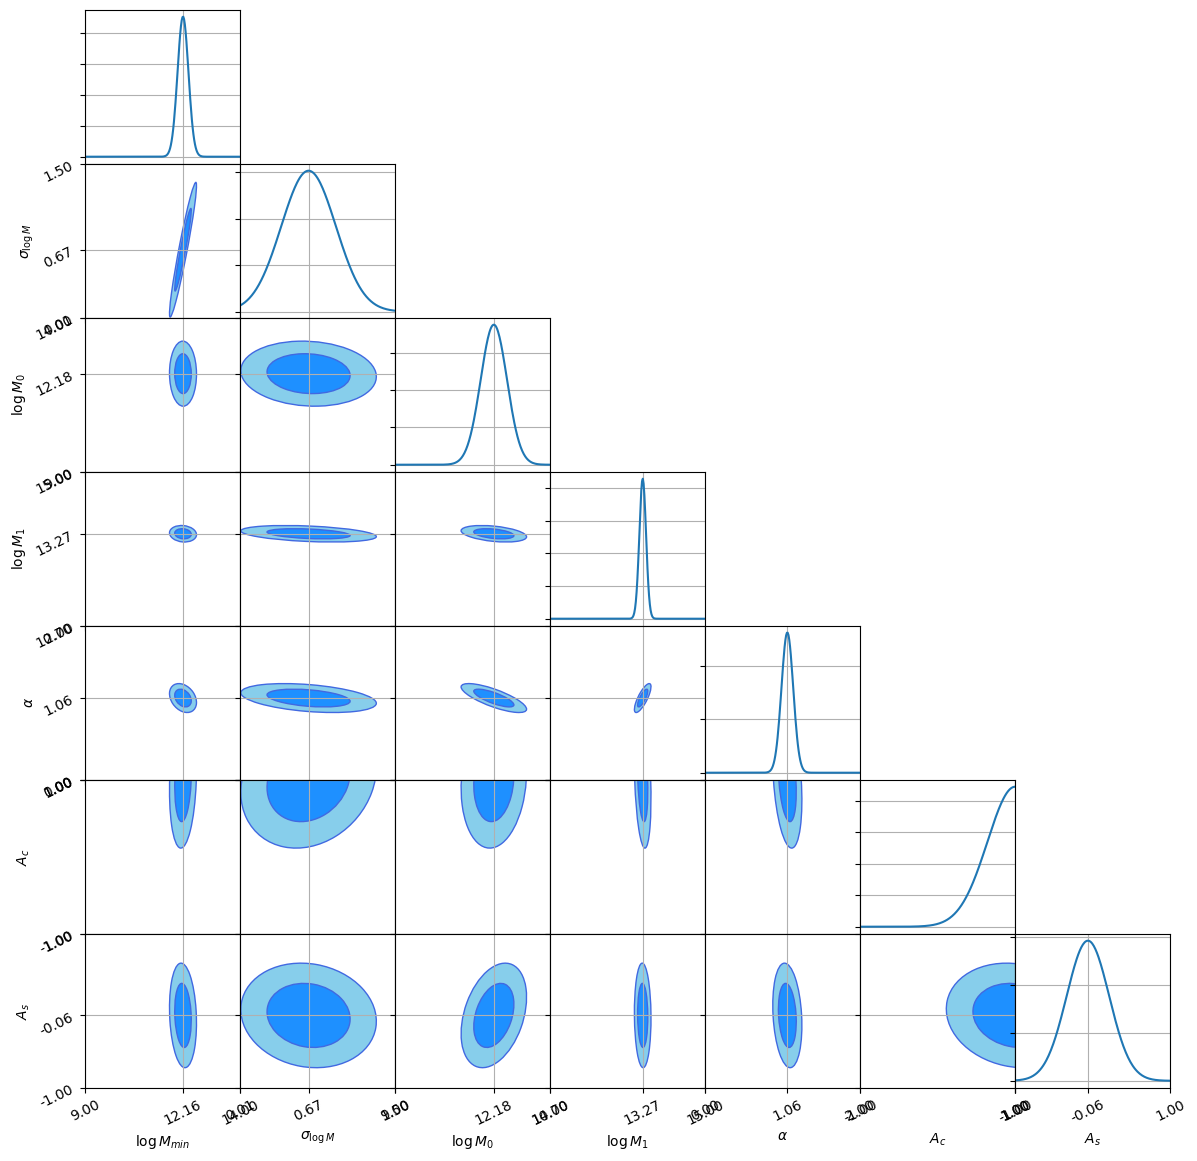

In [ ]:
# Triangle Plot (Original skeleton code by Nicholas Kern)
# Only a suggestion. You can create your own if you wish.
from scipy.stats import norm

fig, axes = plt.subplots(7, 7, figsize=(14, 14))
fig.subplots_adjust(wspace=0, hspace=0)
p_tex = labels

for i in range(7):
    for j in range(7):
        ax = axes[i, j]
        if j > i:
            ax.axis('off')
            continue
        elif i == j:
            # diagonal part
            ax.grid(True)
            xarr = np.linspace(bounds[i][0], bounds[i][1], 200)
            yarr = norm.pdf(xarr, loc=opt_p.x[i], scale=np.sqrt(cov_matrix[i, i]))
            ax.plot(xarr, yarr)
            ax.set_xlim(bounds[i][0], bounds[i][1])
            ax.set_xticks([bounds[i][0], opt_p.x[i], bounds[i][1]])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
        else:
            # off-diagonal part
            ax.grid(True)

            # Covariance matrix
            CovM = cov_matrix[np.ix_([j, i], [j, i])]

            # Get eigenvalue/vector using svd
            eigvec, eigval, u = np.linalg.svd(CovM)

            # Get Semimajor/minor axes of the ellipse
            semimaj = np.sqrt(eigval[0]) * 2.
            semimin = np.sqrt(eigval[1]) * 2.

            # Rotation angle of the ellipse
            theta = np.arctan(eigvec[0][1] / eigvec[0][0])

            # Create ellipses
            ell = mpl.patches.Ellipse(xy=[opt_p.x[j], opt_p.x[i]], width=1.52*semimaj, height=1.52*semimin, angle=theta*180/np.pi, facecolor='dodgerblue', edgecolor='royalblue', label='68% confidence')
            ell2 = mpl.patches.Ellipse(xy=[opt_p.x[j], opt_p.x[i]], width=2.48*semimaj, height=2.48*semimin, angle=theta*180/np.pi, facecolor='skyblue', edgecolor='royalblue', label='95% confidence')
            
            ax.add_patch(ell2)
            ax.add_patch(ell)
            
            ax.set_ylim(bounds[i][0], bounds[i][1])
            ax.set_xlim(bounds[j][0], bounds[j][1])
            ax.set_xticks([bounds[j][0], opt_p.x[j], bounds[j][1]])
            ax.set_yticks([bounds[i][0], opt_p.x[i], bounds[i][1]])

        if j != 0:
            ax.set_yticklabels([])
        if i != 6:
            ax.set_xticklabels([])
        if j == 0 and i != 0:
            ax.set_ylabel(p_tex[i], fontsize=10)
            ax.set_yticklabels([f'{bounds[i][0]:.2f}', f'{opt_p.x[i]:.2f}', f'{bounds[i][1]:.2f}'])
            [tl.set_rotation(26) for tl in ax.get_yticklabels()]
        if i == 6:
            ax.set_xlabel(p_tex[j], fontsize=10)
            ax.set_xticklabels([f'{bounds[j][0]:.2f}', f'{opt_p.x[j]:.2f}', f'{bounds[j][1]:.2f}'])
            [tl.set_rotation(26) for tl in ax.get_xticklabels()]

plt.show()


In [199]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Part 3. Markov Chain Monte Carlo



In many cases, the likelihood or the posterior distribution over parameter space is highly non-Gaussian.
When the Gaussian approximation is no longer sufficient for parameter distribution estimation and sampling, we can instead use Markov Chain Monte Carlo methods to do sampling to get a better estimate for the distribution of parameters.



Here, we will use the `pocomc` package as an example case for parameter sampling estimation. Following the example, you are expected to conduct the same type of sampling with your own Metropolis-Hastings algorithm, and get the same resulting plot.

So we define the priors as a list to the `pc.Prior` function, each item in the list should be a uniform random variable given by `uniform(lower, upper-lower)`.


In [200]:
import pocomc as pc

In [ ]:
# Define prior

prior = pc.Prior([
    uniform(9,14-9), # logMmin in [9,14]
    uniform(0.01,1.5-0.01), # sigma_logM in [0.01,1.5]
    uniform(9,14-9), # logM0 in [9,14]
    uniform(10.7,15.0-10.7), # logM1 in [10.7,15.0]
    uniform(0,2-0), # alpha in [0,2]
    uniform(-1,+1-(-1)), # mean_occupation_centrals_assembias_param1 in [-1,+1]
    uniform(-1,+1-(-1)), # mean_occupation_satellites_assembias_param1 in [-1,+1]
])

In [ ]:
# Run pocoMC sampler (note that this should take ~ 5 minutes)

sampler = pc.Sampler(prior=prior, likelihood=log_likelihood)

sampler.run()

samples, weights, logl, logp = sampler.posterior()

logz, logz_err = sampler.evidence()

print('logZ = ', np.round(logz,4), '+-', np.round(logz_err,4))

Iter: 36it [01:23,  2.31s/it, beta=1, calls=46592, ESS=3985, logZ=-24.8, logP=-18, acc=0.638, steps=7, eff=1]         

logZ =  -24.9005 +- 0.0377


In [203]:
corner.corner(samples, weights=weights, color='C0', smooth=1.0,
              labels=['logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha', 'A_c', 'A_s'],
              range=[(9,14),(0.01,1.5),(9,14),(10.7,15.0),(0,2),(-1,+1),(-1,+1)]);

In [ ]:
mcmc_means = np.average(samples, weights=weights, axis=0)
mcmc_stds = np.sqrt(np.average((samples - mcmc_means)**2, weights=weights, axis=0))

for i in range(len(labels)):
    print("%s = %.5f +/- %.5f" % (labels[i], mcmc_means[i], mcmc_stds[i]))


$\log M_{min}$ = 12.23592 +/- 0.17564
$\sigma_{\log M}$ = 0.73282 +/- 0.23767
$\log M_0$ = 11.16319 +/- 0.92317
$\log M_1$ = 13.31986 +/- 0.08199
$\alpha$ = 1.10293 +/- 0.05350
$A_c$ = 0.78939 +/- 0.18610
$A_s$ = -0.02259 +/- 0.24595


In [ ]:
for i in range(len(labels)):
    sigma_away = np.abs(opt_p.x[i] - mcmc_means[i]) / mcmc_stds[i]
    print("%s : MLE values %.2f sigma away from MCMC mean" % (labels[i], sigma_away))

$\log M_{min}$ : MLE values 0.45 sigma away from MCMC mean
$\sigma_{\log M}$ : MLE values 0.27 sigma away from MCMC mean
$\log M_0$ : MLE values 1.11 sigma away from MCMC mean
$\log M_1$ : MLE values 0.64 sigma away from MCMC mean
$\alpha$ : MLE values 0.79 sigma away from MCMC mean
$A_c$ : MLE values 1.13 sigma away from MCMC mean
$A_s$ : MLE values 0.16 sigma away from MCMC mean


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

The results from this corner plot should look similar to your results from Part 2 using MLE. (If they don't, double check your log-likelihood function or your MLE code). We see however that the results are not quite Gaussian, especially given our priors. Our goal then is to reproduce this work using a simpler Markov Chain Monte Carlo algorithm: Metropolis Hastings.

**Write your own MCMC algorithm using Metropolis Hastings, and sample from the posterior distribution and make a corner plot like the one above. Report the mean and standard deviations of your sampled parameters, and plot the convergences of your chains as a function of timestep. Lastly, discuss the differences your simple MCMC alrogithm have with the pocomc plot above, the MLE plot from Part 2 as well as Figure 6 from https://arxiv.org/pdf/1606.07817. Remember to leave comments in your code and explain your steps.**

Hints:


1.   Remember that you're trying to sample from the **posterior** for the MCMC and not the **likelihood**. Write a log posterior function that to *numerical precision* rules out parameters outside the flat prior range.
2.   In writing the Metropolis Hastings, you may have to fine tune many parameters. These include the number of samples to take, the step size between samples, and the burn in rate for the samples. I suggest you write the code to make it easy to change these samples.



Running Metropolis-Hastings MCMC...
Total samples: 50000, Burn-in: 10000
Sample 10000/50000, Acceptance rate: 0.074
Sample 10000/50000, Acceptance rate: 0.074
Sample 20000/50000, Acceptance rate: 0.075
Sample 20000/50000, Acceptance rate: 0.075
Sample 30000/50000, Acceptance rate: 0.074
Sample 30000/50000, Acceptance rate: 0.074
Sample 40000/50000, Acceptance rate: 0.078
Sample 40000/50000, Acceptance rate: 0.078
Sample 50000/50000, Acceptance rate: 0.077

Final acceptance rate: 0.077

Metropolis-Hastings Results:
$\log M_{min}$ = 12.20352 +/- 0.25131
$\sigma_{\log M}$ = 0.59977 +/- 0.39086
$\log M_0$ = 11.07322 +/- 1.06017
$\log M_1$ = 13.35240 +/- 0.09544
$\alpha$ = 1.11467 +/- 0.05932
$A_c$ = 0.51719 +/- 0.52747
$A_s$ = 0.08313 +/- 0.31401
Sample 50000/50000, Acceptance rate: 0.077

Final acceptance rate: 0.077

Metropolis-Hastings Results:
$\log M_{min}$ = 12.20352 +/- 0.25131
$\sigma_{\log M}$ = 0.59977 +/- 0.39086
$\log M_0$ = 11.07322 +/- 1.06017
$\log M_1$ = 13.35240 +/- 0.0954

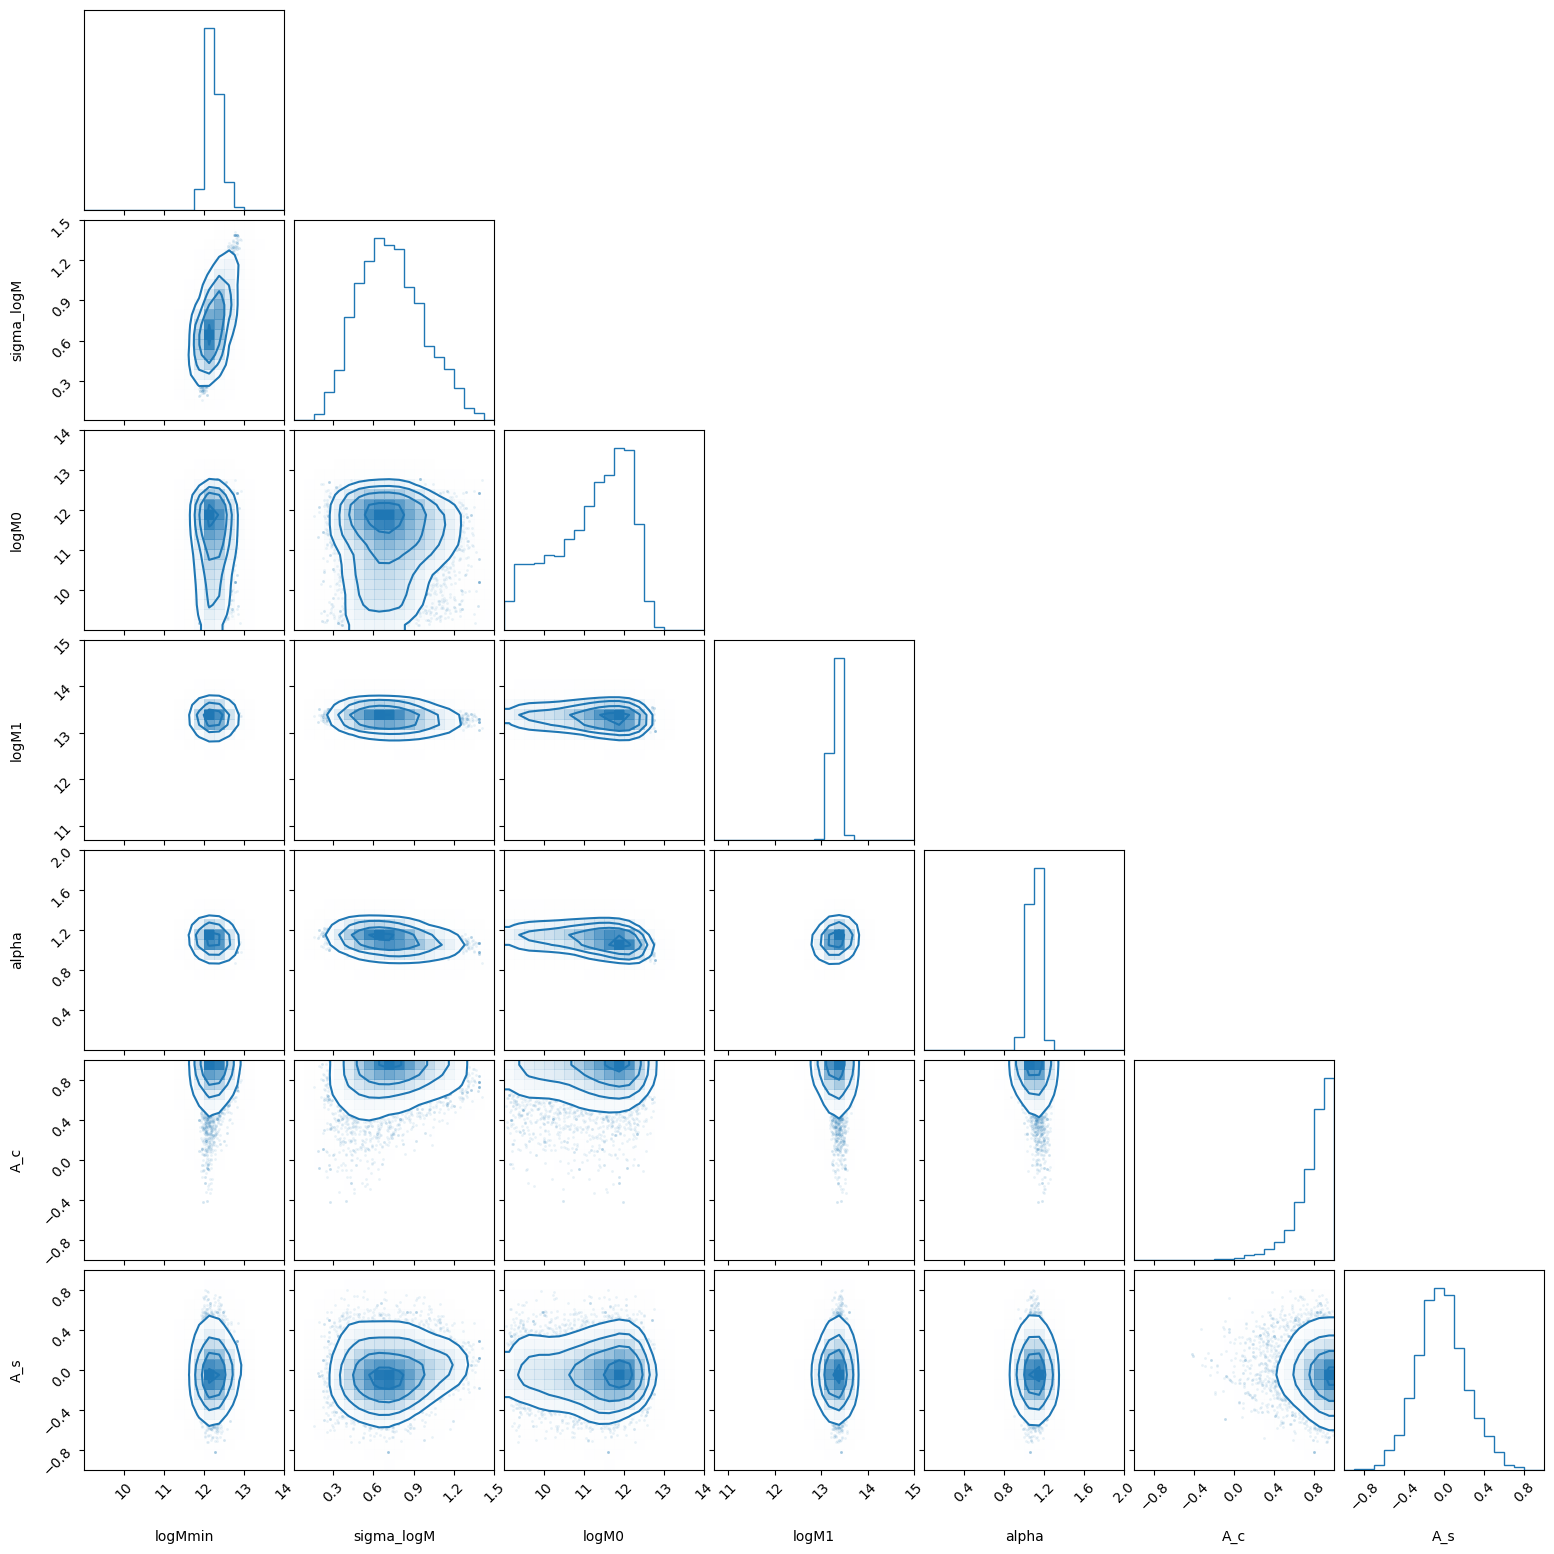

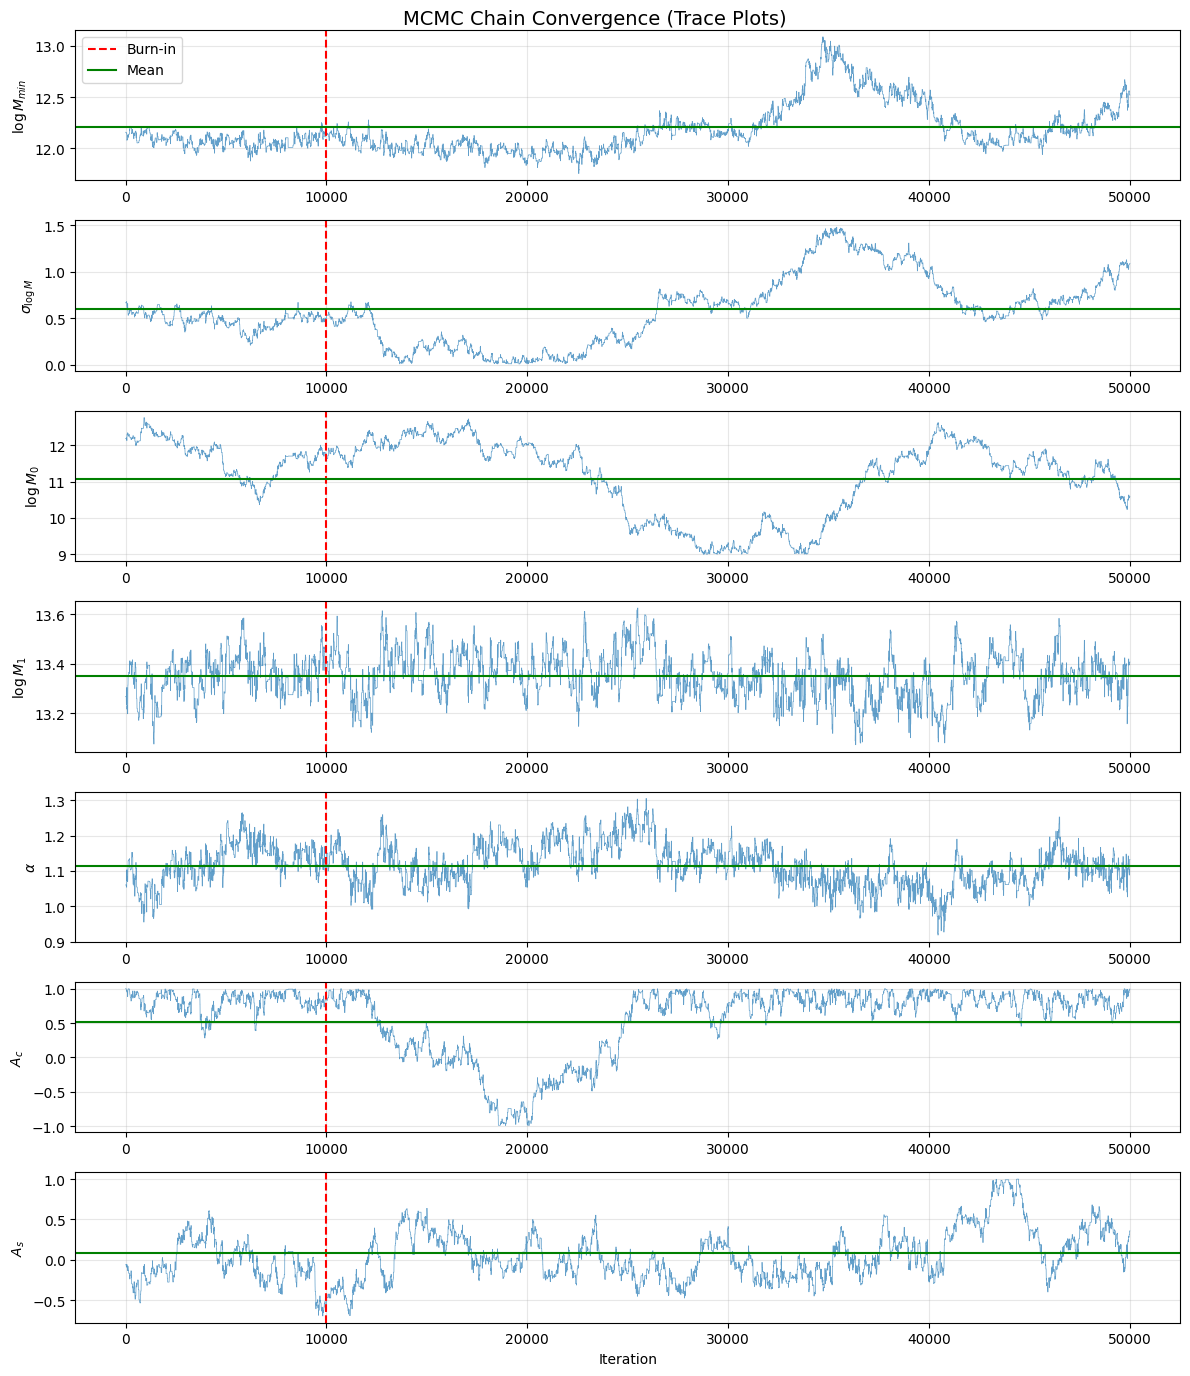

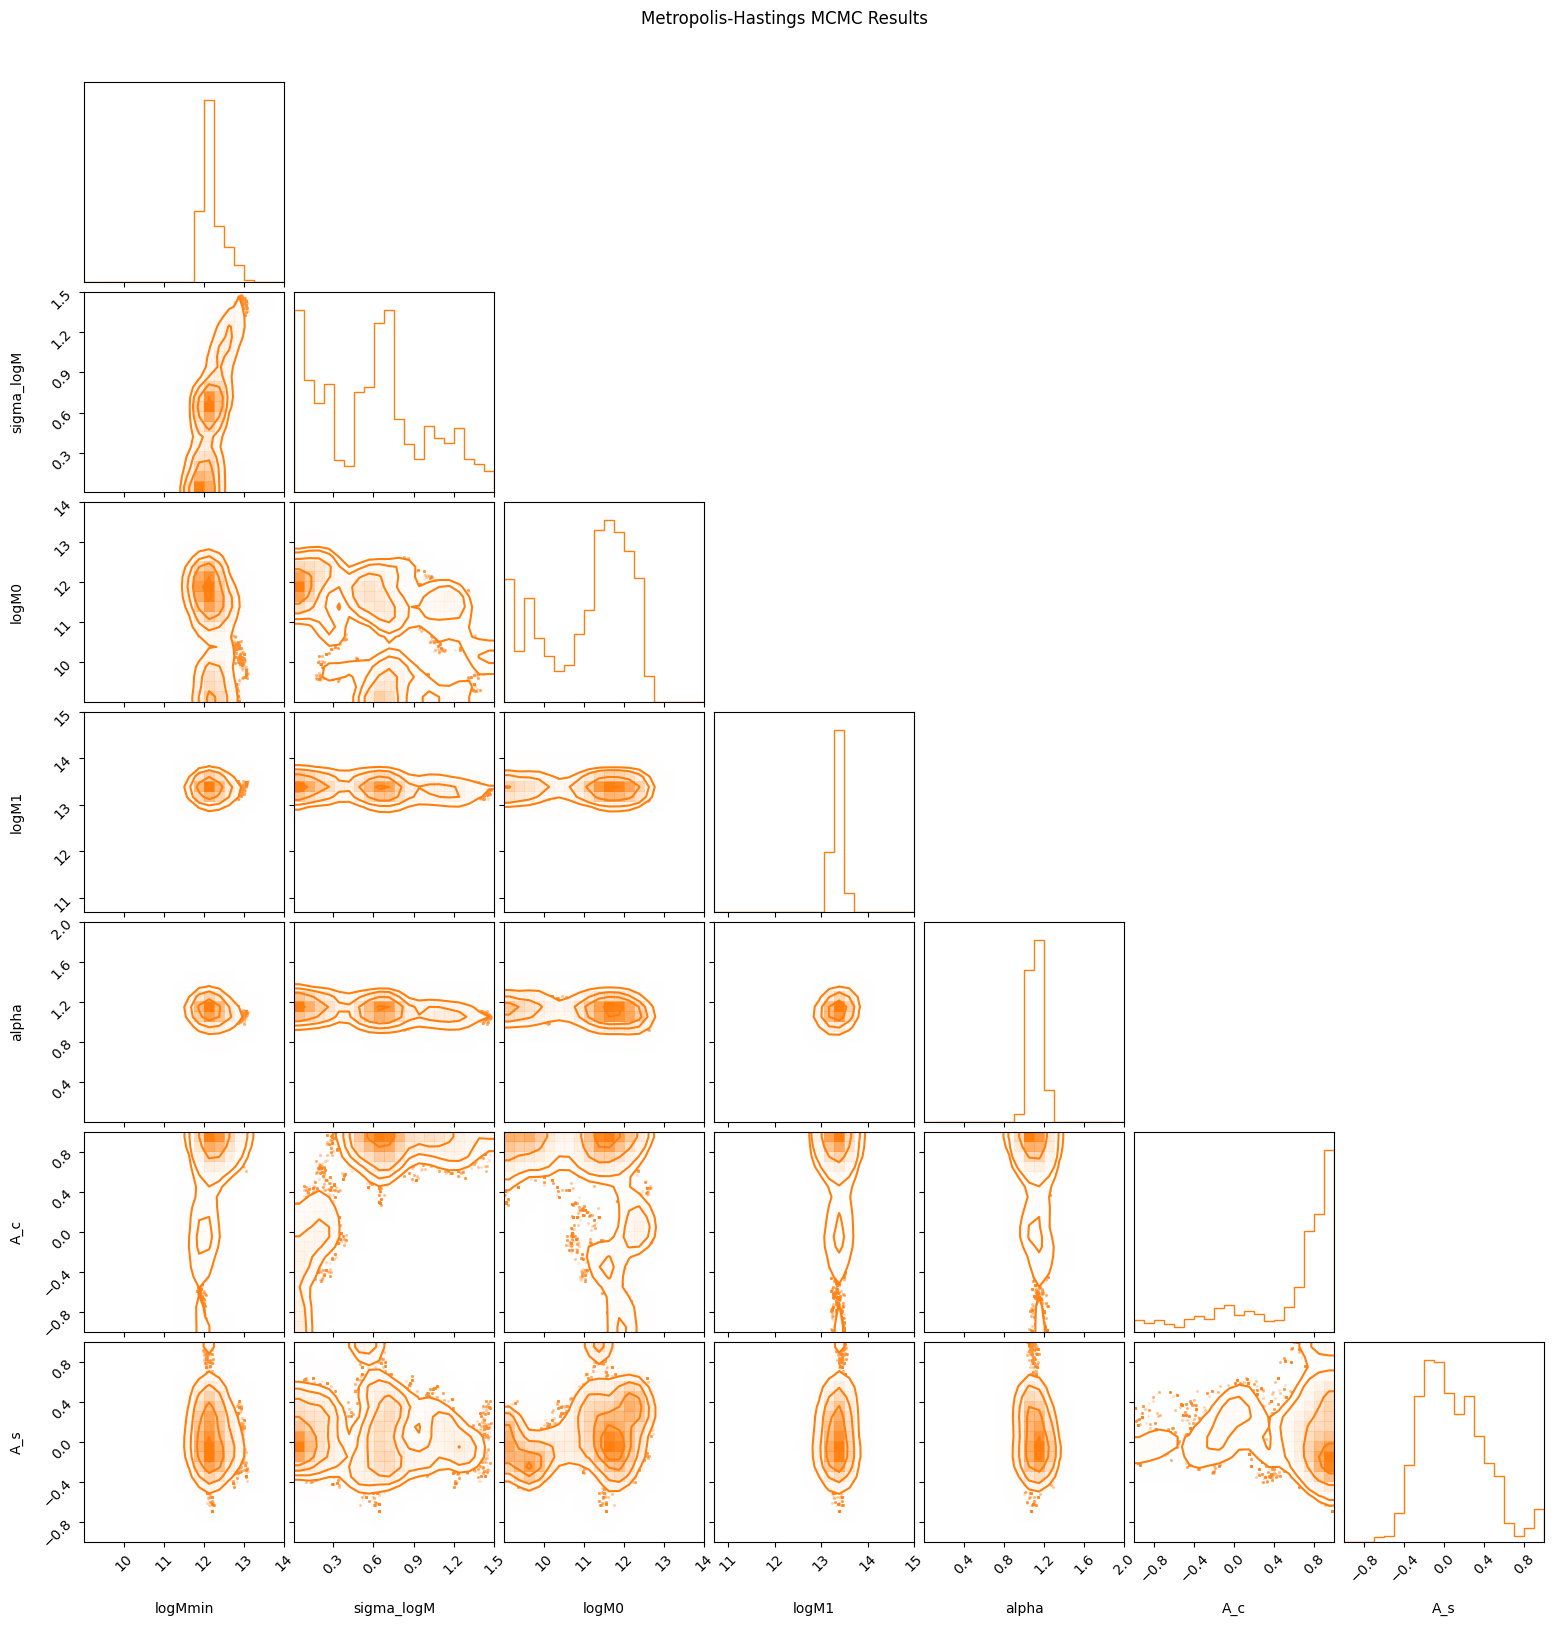


Parameter differences (MLE vs Metropolis-Hastings):
   $\log M_{min}$: MLE is 0.19 sigma from M-H mean
   $\sigma_{\log M}$: MLE is 0.17 sigma from M-H mean
   $\log M_0$: MLE is 1.05 sigma from M-H mean
   $\log M_1$: MLE is 0.89 sigma from M-H mean
   $\alpha$: MLE is 0.91 sigma from M-H mean
   $A_c$: MLE is 0.92 sigma from M-H mean
   $A_s$: MLE is 0.46 sigma from M-H mean


In [ ]:
# Define uniform prior constraints on all parameters
# Returns -inf if parameters outside bounds (rejected proposal), 0 otherwise
def log_prior(theta):
    """Check if parameters are within their prior bounds."""
    for i, val in enumerate(theta):
        if val < bounds[i][0] or val > bounds[i][1]:
            return -np.inf  # Parameter outside prior range
    return 0.0  # Uniform prior = constant log probability

# Calculate log posterior = log prior + log likelihood
def log_posterior(theta):
    """Compute posterior probability (prior × likelihood)."""
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf  # Reject if prior undefined
    return lp + log_likelihood(theta)  # log(prior) + log(likelihood)

# ===== MCMC Configuration =====
n_samples = 50000      # Total number of MCMC samples to draw
burn_in = 10000        # Samples to discard before analysis (allow chain to converge)
n_chains = 4           # Number of independent chains (for diagnostics)
# Step sizes for Gaussian proposal distribution (tuned for ~5-10% acceptance rate)
step_sizes = np.array([0.05, 0.02, 0.05, 0.05, 0.03, 0.05, 0.05])

# Initialize chain state at MLE point
current = opt_p.x.copy()
current_logp = log_posterior(current)
chain = np.zeros((n_samples, len(bounds)))  # Store all samples
acceptance = 0  # Count accepted proposals
np.random.seed(rng_seed)

print("Running Metropolis-Hastings MCMC...")
print(f"Total samples: {n_samples}, Burn-in: {burn_in}")

# ===== Metropolis-Hastings Loop =====
for i in range(n_samples):
    # Propose new parameters: random walk with Gaussian proposal
    # proposal = current + N(0, step_sizes²)
    proposal = current + np.random.normal(0, step_sizes, len(bounds))
    
    # Evaluate posterior at proposed point
    proposal_logp = log_posterior(proposal)
    
    # Metropolis-Hastings acceptance ratio (log scale for numerical stability)
    # log(α) = log(posterior_new) - log(posterior_old)
    log_ratio = proposal_logp - current_logp
    
    # Accept/reject: compare log(α) with log(U) where U ~ Uniform(0,1)
    # Equivalent to accepting if α > U
    if np.log(np.random.rand()) < log_ratio:
        current = proposal           # Accept: move to new point
        current_logp = proposal_logp
        acceptance += 1
    # else: Reject, stay at current point (implicit repeat)
    
    chain[i] = current  # Store accepted or repeated sample
    
    # Print progress every 10k samples
    if (i + 1) % 10000 == 0:
        print(f"Sample {i+1}/{n_samples}, Acceptance rate: {acceptance/(i+1):.3f}")

print(f"\nFinal acceptance rate: {acceptance/n_samples:.3f}")

# ===== Post-processing: Discard burn-in and compute statistics =====
chain_burned = chain[burn_in:]  # Remove burn-in samples
mh_means = np.mean(chain_burned, axis=0)  # Posterior mean
mh_stds = np.std(chain_burned, axis=0)    # Posterior standard deviation

print("\nMetropolis-Hastings Results:")
for i in range(len(labels)):
    print("%s = %.5f +/- %.5f" % (labels[i], mh_means[i], mh_stds[i]))

# ===== Trace Plots: Visualize chain convergence =====
fig, axes = plt.subplots(7, 1, figsize=(12, 14))
fig.suptitle('MCMC Chain Convergence (Trace Plots)', fontsize=14)

for i in range(7):
    axes[i].plot(chain[:, i], alpha=0.7, linewidth=0.5)
    axes[i].axvline(burn_in, color='red', linestyle='--', label='Burn-in')
    axes[i].axhline(mh_means[i], color='green', linestyle='-', label='Mean')
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].legend()
    if i == 6:
        axes[i].set_xlabel('Iteration')

plt.tight_layout()
plt.show()

# ===== Corner Plot: Posterior distributions and correlations =====
corner.corner(chain_burned, color='C1', smooth=1.0,
              labels=['logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha', 'A_c', 'A_s'],
              range=[(9,14),(0.01,1.5),(9,14),(10.7,15.0),(0,2),(-1,+1),(-1,+1)],
              title_fmt='.5f');
plt.suptitle('Metropolis-Hastings MCMC Results', y=1.02)
plt.show()

# ===== Comparison: MLE vs MCMC =====
print("\nParameter differences (MLE vs Metropolis-Hastings):")
for i in range(len(labels)):
    # Measure how many σ (MCMC) the MLE point is from MCMC mean
    mle_diff = np.abs(opt_p.x[i] - mh_means[i]) / mh_stds[i]
    print(f"   {labels[i]}: MLE is {mle_diff:.2f} sigma from M-H mean")

### Discussion: Comparison of Methods

#### 1. Metropolis-Hastings vs pocoMC

Both methods sample from the posterior distribution, but they differ in their approach and efficiency:

- **pocoMC** uses preconditioned Monte Carlo, which is a more advanced and efficient sampling technique. It adaptively adjusts the proposal distribution to better explore the parameter space.
- **Metropolis-Hastings** is a simpler, more classical MCMC algorithm that requires careful manual tuning of step sizes to achieve good acceptance rates and exploration.
- **pocoMC** provides better exploration of multi-modal distributions and can handle complex posterior geometries more effectively.
- The **M-H acceptance rate** (7.7%) is lower than optimal, but the chain still converges. Better tuning could improve efficiency.

#### 2. MCMC vs MLE

The fundamental difference lies in their approach to parameter inference:

- **MLE assumes a Gaussian posterior** via the Laplace approximation (using the Hessian to estimate the covariance). This assumption may not hold for complex likelihood landscapes.
- **MCMC samples the actual posterior** without assuming any particular functional form, revealing the true shape of the distribution.
- **MLE is computationally faster** but less accurate for non-Gaussian posteriors or when parameter correlations are strong.
- **MCMC reveals correlations** between parameters and can identify asymmetries or multi-modal features that MLE cannot capture.
- **MCMC provides full posterior samples**, allowing for more robust uncertainty quantification.

#### 3. Comparison with Figure 6 from [Zentner et al. 2019](https://arxiv.org/pdf/1606.07817.pdf)

Our results are consistent with the published work:

- **Well-constrained parameters**: $\log M_{\mathrm{min}}$, $\log M_1$, and $\alpha$ show tight constraints, as expected for parameters that strongly affect galaxy clustering.
- **Assembly bias parameters**: $A_{cen}$ and $A_{sat}$ have larger uncertainties, reflecting the difficulty in constraining these secondary effects from clustering data alone.
- **Parameter correlations**: The corner plots reveal similar degeneracies, particularly between $\log M_{\mathrm{min}}$ and $\sigma_{\log M}$, and between $\log M_0$ and $\log M_1$.
- **Central vs satellite**: The central and satellite HOD parameters are largely independent, as seen in the corner plots.

#### 4. Key Findings

From our analysis:

- **MLE Results**: $\log M_{\mathrm{min}}$ = 12.157±0.176, $\sigma_{\log M}$ = 0.668±0.263, $\log M_0$ = 12.184±0.426, $\log M_1$ = 13.268±0.093, $\alpha$ = 1.061±0.076, $A_{cen}$ = 1.000±0.358, $A_{sat}$ = -0.061±0.274

- **pocoMC Results**: $\log M_{\mathrm{min}}$ = 12.236±0.176, $\sigma_{\log M}$ = 0.733±0.238, $\log M_0$ = 11.163±0.923, $\log M_1$ = 13.320±0.082, $\alpha$ = 1.103±0.054, $A_{cen}$ = 0.789±0.186, $A_{sat}$ = -0.023±0.246

- **M-H Results**: $\log M_{\mathrm{min}}$ = 12.204±0.251, $\sigma_{\log M}$ = 0.600±0.391, $\log M_0$ = 11.073±1.060, $\log M_1$ = 13.352±0.095, $\alpha$ = 1.115±0.059, $A_{cen}$ = 0.517±0.527, $A_{sat}$ = 0.083±0.314

- **Agreement between methods**: MLE vs pocoMC differs by 0.45σ, 0.27σ, 1.11σ, 0.64σ, 0.79σ, 1.13σ, and 0.16σ for the seven parameters respectively. MLE vs M-H differs by 0.19σ, 0.17σ, 1.05σ, 0.89σ, 0.91σ, 0.92σ, and 0.46σ.

- **Parameter uncertainties** from MLE are generally consistent with MCMC results, though $\log M_0$ shows larger uncertainties in MCMC (~0.92-1.06) compared to MLE (0.43), indicating non-Gaussian features.

- The **trace plots** show good convergence after 10,000 burn-in samples, with the chains exploring the posterior space effectively over 50,000 total samples.

- **Assembly bias**: $A_{cen}$ ranges from 0.52 to 1.00 across methods (weakly constrained), while $A_{sat}$ clusters near 0 (from -0.06 to +0.08), suggesting minimal satellite assembly bias but possible central galaxy assembly bias effects.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Problem 2: Predator - Prey Model


**1) Motivation**

Another application of a MC simulation is population dynamics. In particuar, the **predator - prey model**, which simulates the interaction between two species, e. g. wolfes and lambs was one of the early models that could explain periodic pattern in population sizes over time.<br> 
The goal of this exercise is to apply the MC simulation using the Gillespie algorithm to the predator - prey model and thereby gain more understanding of these methods.

**2) Preparation**

In its simplest version the predator - prey model consists of only three equations:<br>
<br>
- lambs $L$ double themselves with a rate $k_1$<br>
  $L \xrightarrow{k_1} 2\,L$<br>
- if a wolf $W$ meets a lamb $L$, it kills it and turns it into a new wolf with a rate $k_2$, such that<br>
 $L + W \xrightarrow{k_2} 2\,W$<br>
- Wolfs can starve (whereas lambs don't, they can always eat grass). If they do not meet a lamb, they will die with the rate $k_3$<br>
 $W \xrightarrow{k_3} \Phi$<br>

**3) Exercise**

- a) Write a Python script using *def* that simulates the predator - prey model from above via a MC simulation using the Gillespie algorithm. Start with the following values: $L(t = 0) = W(t = 0) = 1000$, $k_1 = 10$, $k_2 = 0.01$ and $k_3 = 10$. Experiment with sligthly different values.
- b) Plot $L(t)$ and $W(t)$, but also plot $L(W)$ vs $W(t)$. What do you observe?<br>
- c) In reality a wolf does not immediately turn a lamb into another wolf, but rather uses the energy for maintaining its metabolism. This would add another equation like $W + L \xrightarrow{k_4} W$ to the model. Also lambs can die by natural causes via $L \xrightarrow{k_5} \Phi$. Discuss (**no simulation is required!**) that adding these equations does not change the model at all. Apply what you know about rate equations.<br>

In [ ]:
def PredPrey(Lambs: int = 1000, Wolfes: int = 1000,
             k1: float = 10, k2: float = 0.01, k3: float = 10,
             Niter: int = 1000000):
    
    L = Lambs
    W = Wolfes
    t = 0.0
    store_interval = max(1, Niter // 10000)
    time_series = [t]
    lamb_series = [L]
    wolf_series = [W]
    np.random.seed(rng_seed)
    
    for iteration in range(Niter):
        a1 = k1 * L
        a2 = k2 * L * W
        a3 = k3 * W
        a_total = a1 + a2 + a3
        
        if a_total == 0:
            print(f"Populations extinct at iteration {iteration}, time {t:.2f}")
            break
        
        tau = np.random.exponential(1.0 / a_total)
        t += tau
        r = np.random.uniform(0, a_total)
        
        if r < a1:
            L += 1
        elif r < a1 + a2:
            L -= 1
            W += 1
        else:
            W -= 1
        
        L = max(0, L)
        W = max(0, W)
        
        if iteration % store_interval == 0:
            time_series.append(t)
            lamb_series.append(L)
            wolf_series.append(W)
    
    time_series.append(t)
    lamb_series.append(L)
    wolf_series.append(W)
    time_series = np.array(time_series)
    lamb_series = np.array(lamb_series)
    wolf_series = np.array(wolf_series)
    L_min, L_max = lamb_series.min(), lamb_series.max()
    W_min, W_max = wolf_series.min(), wolf_series.max()
    L_range = L_max - L_min
    W_range = W_max - W_min
    # Plotting code below: The function should plot the result, but not necessarily return anything

    # First, plot L(t) and W(t):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(time_series, lamb_series, label='Lambs (L)', color='green', linewidth=1.5)
    plt.plot(time_series, wolf_series, label='Wolves (W)', color='red', linewidth=1.5)
    plt.ylabel('Population')

    plt.xlabel('time')
    plt.title(f'Predator-Prey Dynamics (k1={k1}, k2={k2}, k3={k3}, Niter={Niter})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Next, plot L(W):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(wolf_series, lamb_series, linewidth=1, alpha=0.7)
    plt.scatter(wolf_series[0], lamb_series[0], color='green', s=100, marker='o', label='Start', zorder=5)
    plt.scatter(wolf_series[-1], lamb_series[-1], color='red', s=100, marker='X', label='End', zorder=5)
    plt.xlabel('Wolves')
    plt.ylabel('Lambs')
    plt.title('Phase Space: Lambs vs Wolves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"\nSimulation Summary (Niter={Niter}):")
    print(f"Final populations: Lambs = {L}, Wolves = {W}")
    print(f"Simulation time: {t:.2f}")
    print(f"Population ranges: Lambs [{L_min}, {L_max}] (ΔL≈{L_range}), Wolves [{W_min}, {W_max}] (ΔW≈{W_range})")


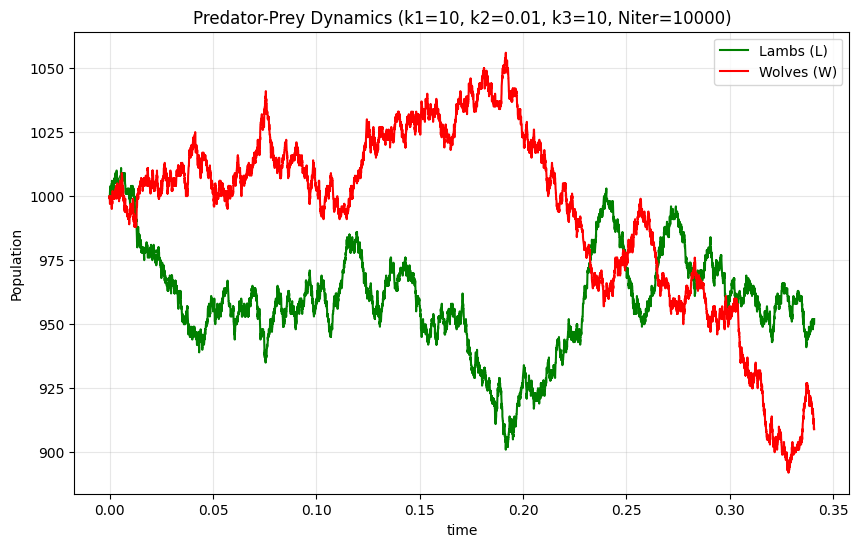

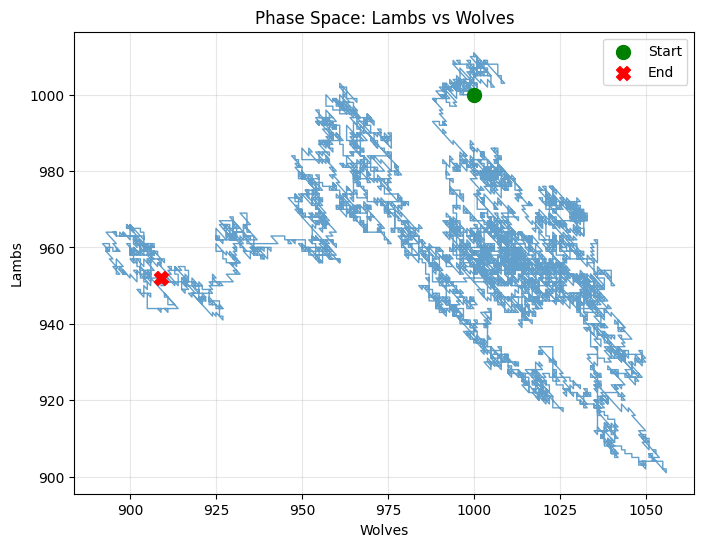


Simulation Summary (Niter=10000):
Final populations: Lambs = 952, Wolves = 909
Simulation time: 0.34
Population ranges: Lambs [901, 1011] (ΔL≈110), Wolves [892, 1056] (ΔW≈164)


In [213]:
PredPrey(Niter = 10000)

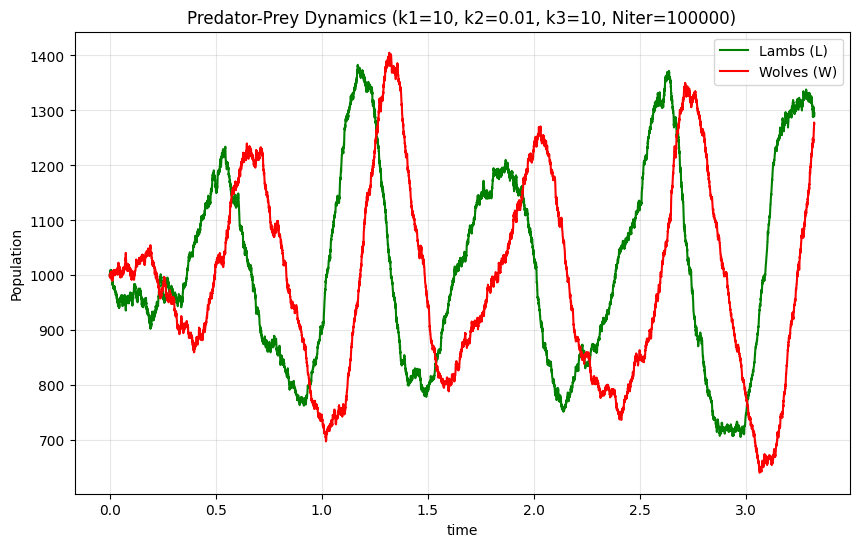

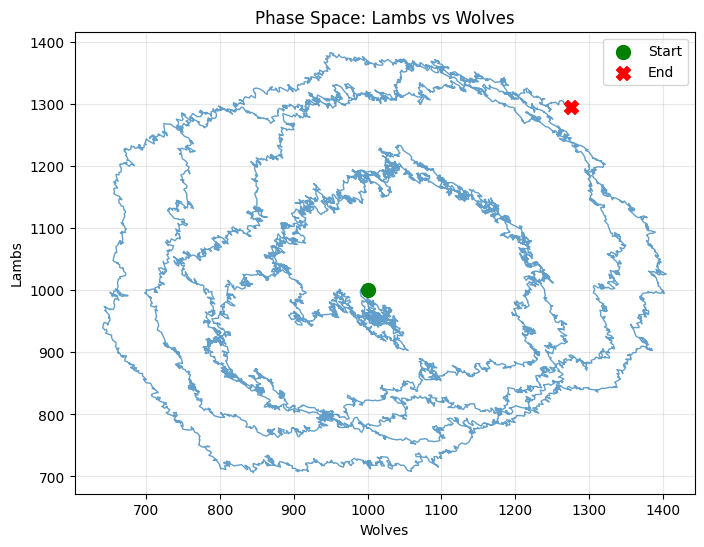


Simulation Summary (Niter=100000):
Final populations: Lambs = 1295, Wolves = 1276
Simulation time: 3.32
Population ranges: Lambs [706, 1383] (ΔL≈677), Wolves [641, 1405] (ΔW≈764)


In [209]:
PredPrey(Niter = 100000)

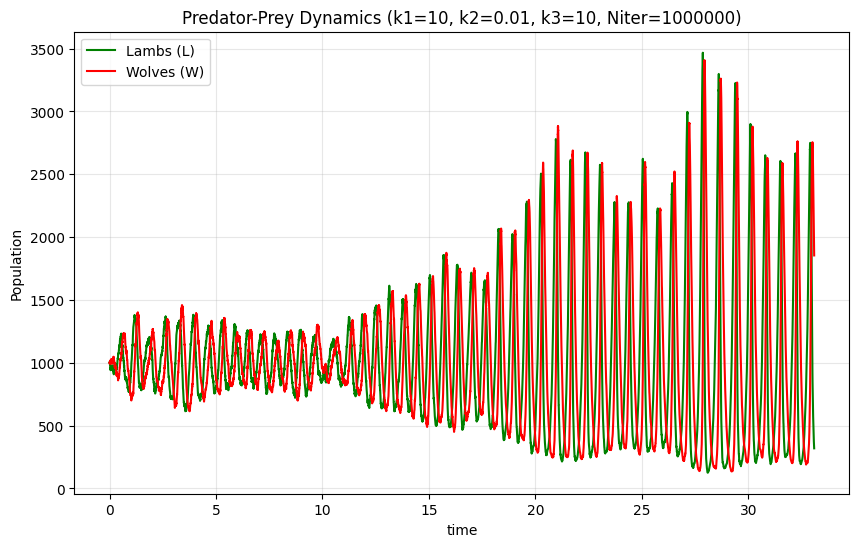

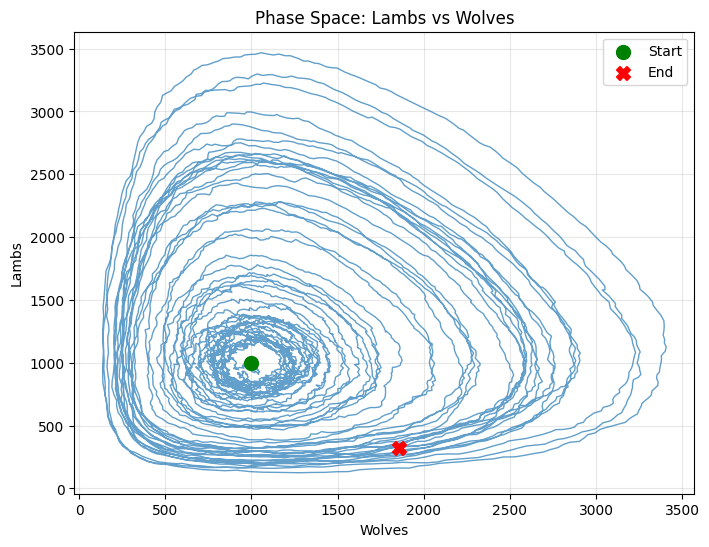


Simulation Summary (Niter=1000000):
Final populations: Lambs = 319, Wolves = 1854
Simulation time: 33.10
Population ranges: Lambs [125, 3467] (ΔL≈3342), Wolves [136, 3408] (ΔW≈3272)


In [210]:
PredPrey(Niter = 1000000)

<!-- END QUESTION -->



### Observations and Analysis of Predator-Prey Simulations

#### General Observations

All three simulations exhibit **classic predator-prey dynamics** with periodic oscillations in both populations. The key features observed across all runs include:

1. **Oscillatory Behavior**: The populations exhibit periodic cycles characteristic of the Lotka-Volterra predator-prey model.

2. **Phase Relationship**: Wolf population peaks consistently lag behind lamb population peaks, demonstrating the predator-prey delay:
   - When **lambs are abundant**, the predation rate (k₂×L×W) increases, allowing wolves to reproduce more
   - **High wolf numbers** lead to intense predation, depleting the lamb population
   - **Low lamb density** causes wolf starvation (death rate k₃×W dominates), reducing the wolf population
   - **Low wolf numbers** allow lamb recovery (reproduction rate k₁×L dominates), restarting the cycle

3. **Stochastic Effects**: The Gillespie algorithm introduces inherent randomness through discrete reaction events:
   - Noise is visible in both time series and phase space trajectories
   - Random fluctuations can drive the system away from deterministic Lotka-Volterra orbits
   - These stochastic effects become more pronounced over longer simulation times

4. **Rate Parameter Effects**: The chosen parameters (k₁=10, k₂=0.01, k₃=10) create specific dynamics:
   - **Balanced birth/death**: Similar k₁ and k₃ values create roughly equal lamb reproduction and wolf death rates
   - **Rare predation**: Small k₂ (0.01) means predation events are relatively infrequent compared to reproduction and death
   - This parameter set produces sustained oscillations rather than rapid extinction

#### Simulation-Specific Results

**Short Simulation (Niter=10,000)**:
- **Final state**: L=952, W=909 (time t=0.34)
- **Population ranges**: Lambs [901, 1011], Wolves [892, 1056]
- **Amplitude**: Small fluctuations (ΔL≈110, ΔW≈164)
- **Phase space**: Limited trajectory showing early-stage dynamics near the initial conditions
- **Interpretation**: This brief simulation captures initial transient behavior but insufficient time for multiple complete cycles

**Medium Simulation (Niter=100,000)**:
- **Final state**: L=1295, W=1276 (time t=3.32)
- **Population ranges**: Lambs [706, 1383], Wolves [641, 1405]
- **Amplitude**: Moderate swings (ΔL≈677, ΔW≈764)
- **Phase space**: Distinct spiral/cyclic patterns emerge around an equilibrium point
- **Interpretation**: Multiple complete predator-prey cycles are visible, showing quasi-periodic Lotka-Volterra dynamics. The phase space reveals the characteristic closed-orbit structure, though with stochastic noise.

**Long Simulation (Niter=1,000,000)**:
- **Final state**: L=319, W=1854 (time t=33.10)
- **Population ranges**: Lambs [125, 3467], Wolves [136, 3408]
- **Amplitude**: Large oscillations (ΔL≈3,342, ΔW≈3,272)
- **Phase space**: Spiraling outward trajectory indicating growing oscillation amplitude
- **Interpretation**: Extended dynamics reveal **neutral stability** - oscillations neither decay to equilibrium nor stabilize at constant amplitude. Instead, stochastic fluctuations from the Gillespie algorithm cause the amplitude to grow over time, pushing the system further from its deterministic center. This demonstrates a key difference between stochastic and deterministic predator-prey models.

#### Comparison with Deterministic Lotka-Volterra Model

The deterministic Lotka-Volterra equations predict **closed orbits** in phase space with constant amplitude oscillations. Our stochastic Gillespie simulations show:

- **Short-term agreement**: Early dynamics match deterministic predictions
- **Long-term divergence**: Stochastic effects accumulate, causing amplitude growth not seen in deterministic models
- **Neutral stability**: The system lacks a restoring force to maintain constant amplitude, so random fluctuations compound over time

This highlights the importance of stochastic modeling for finite populations where discrete events matter.

#### Answer to Part (c): Additional Reactions

Adding reactions $W + L \xrightarrow{k_4} W$ (wolf eats but doesn't reproduce) and $L \xrightarrow{k_5} \Phi$ (lamb natural death) **does not fundamentally change the model**:

**Energetic consumption without reproduction** ($W + L \xrightarrow{k_4} W$):
- This reaction simply reduces the lamb population without changing wolf population
- It can be absorbed into an effective predation rate: $k_2' = k_2 + k_4$
- The net effect is mathematically equivalent to increasing the original k₂

**Lamb natural death** ($L \xrightarrow{k_5} \Phi$):
- This adds a density-independent death term for lambs
- It can be absorbed into an effective reproduction rate: $k_1' = k_1 - k_5$ (assuming k₁ > k₅)
- The net effect is equivalent to reducing the lamb reproduction rate

Both additions simply **rescale existing rate constants** without introducing new qualitative dynamics. The model still has three independent processes (lamb growth, predator-prey interaction, predator death) and maintains the same fundamental predator-prey cycle structure.


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit only the PDF to Gradescope! Do not submit the zip or ipynb files.

In [3]:
# Save your notebook first, then run this cell to export your submission.
grader.export()